<a href="https://colab.research.google.com/github/0tt00t/ECS170-Project/blob/main/Fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Writeup

For the writeup, please include the following information:


*   Convolutional neural network: 
-  - An input layer, hidden layers, and an output layer make up a convolutional neural network. Any middle layers in a feed-forward neural network are referred to as hidden layers since the activation function and final convolution hide their inputs and outputs. The convolution procedure develops a feature map as the convolution kernel moves across the input matrix for the layer.

*   Discuss how you tuned your network and why you think it's performance is reasonable for this task


- - Initially, I tried to use three fully connected layer, but the percising rate got stucked on about 85%. Then, I tried to add another layer and adjust the input layer match the matrix(which is the 9216). I choose two convolutional layer with kernel size 2. This is because comparing to the RGB pictures, the black and white pictures need more percise examination. What's more, for the learning rate, we found out that the learning rate 0.015 will be most productive. Finally, we set epouch to 20. Even though sometimes the model shows overstudy, but most of the time will get over 90% accuricy. Combinating all the variables we tuned, we got our final model.

*   Discuss wether or not you feel that this classifier is appropriate for the given task (check PA3 description)

- - When we train our model, the accuracy of our model is 80% at our first epoch. Since we set the number of epoch to 20, the accuracy of our model keeps rising as we get to 20 epochs. In the end, the accuracy of our model can go up to 9029/10000 which is 90%. In this case, if we implement our model to the shipping facility. There is only one wrong selection in 10 clothes. As we get the wrong result, we can learn from the wrong result and keeps upgrade the accuracy of our model.

# PyTorch

## 0 Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. Set Hyperparameters

In [ ]:
# You can modify these values

n_epochs = 20
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.015
momentum = 0.5
log_interval = 100

## 2. Load Data

In [ ]:
train_set = torchvision.datasets.FashionMNIST(
  root = './data/FashionMNIST',
  train = True,
  download = True,
  transform = transforms.Compose([
      transforms.ToTensor()                                 
  ]))

train_loader = torch.utils.data.DataLoader(train_set,
                                     batch_size = batch_size_train,
                                     shuffle=True)

train_set = torchvision.datasets.FashionMNIST(
  root = './data/FashionMNIST',
  train = False,
  download = True,
  transform = transforms.Compose([
      transforms.ToTensor()                                 
  ]))

test_loader = torch.utils.data.DataLoader(train_set,
                                     batch_size = batch_size_train,
                                     shuffle=True)

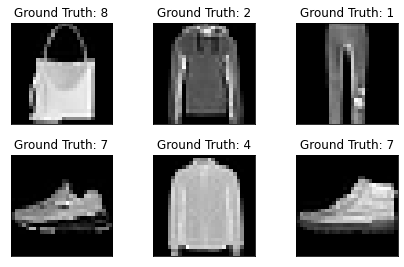

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [ ]:
INPUT_CHANNELS = example_data.shape[1]

OUTPUT_CLASSES = 10
example_data.shape

torch.Size([64, 1, 28, 28])

## 3. Define Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input channels, output channels, kernel size, stride
        self.conv1 = nn.Conv2d(INPUT_CHANNELS, 128, 2, 1)
        self.conv2 = nn.Conv2d(128, 256, 2, 1)
        self.maxPooling = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(9216, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, OUTPUT_CLASSES)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxPooling(x)
        x = self.conv2(x)
        x = self.maxPooling(x)
        linearize = nn.Flatten()
        x = linearize(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
net = Net().to(device)
net

Net(
  (conv1): Conv2d(1, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (maxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

## 4. Train Model

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.MSELoss()

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(net, train_loader, optimizer, epoch)
  test(net, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326385
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.823768
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.672040
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.724265
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.643394
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.407877
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.627572
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.447640
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.394048
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.479826

Test set: Average loss: 0.5574, Accuracy: 8015/10000 (80%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.409819
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.384002
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.413823
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.506972
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.413249
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.438667
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.423068
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.400868
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.352968
T

# Tensorflow

## 0. Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

## 1. Set Hyperparameters

In [ ]:
# Tune these

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01

## 2. Import Data

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size_train)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size_test)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## 3. Define Model

In [ ]:
model = tf.keras.models.Sequential([
  ## Your architecture goes here
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

## 4. Train Model

In [ ]:
model.fit(
    ds_train,
    epochs=n_epochs,
    validation_data=ds_test,
)

Epoch 1/3


InvalidArgumentError: ignored